In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import mlflow
import matplotlib.pyplot as plt
import seaborn as sns
import 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

import warnings

warnings.filterwarnings('ignore')

# Configs and Variables

In [2]:
MLFLOW_TRACKING_URI = 'http://127.0.0.1:5000'

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment('portugal-rent-price')

<Experiment: artifact_location='s3://final-project-mlops/airflow/1', creation_time=1688139905984, experiment_id='1', last_update_time=1688139905984, lifecycle_stage='active', name='portugal-rent-price', tags={}>

In [3]:
TRAIN_DATA_PATH = '../data/processed/train.parquet'
VAL_DATA_PATH = '../data/processed/val.parquet'

# Functions

In [4]:
def read_dataset(filename: str) -> pd.DataFrame:
    df = pd.read_parquet(filename)
    
    df['property_ads'] = df.company.apply(lambda x: 'private' if x == 'Anúncio Particular' else 'private')
    
    data = df.drop(['price'], axis=1)
    target = df['price']
    
    return (data, target)

In [5]:
def one_hot_encode(data, column, encoder):
    encoded = encoder.transform(data[column])
    ohe_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out())
    #concat with original data
    data = pd.concat([data, ohe_df], axis=1).drop(column, axis=1)

    return data

# Load Data

In [6]:
X_train, y_train = read_dataset(TRAIN_DATA_PATH)
X_val, y_val = read_dataset(VAL_DATA_PATH)

In [7]:
# Fazer isso no pre-processamento
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)


In [8]:
print('Train dataset:', X_train.shape)
print('Val dataset:', X_val.shape)

Train dataset: (2555, 11)
Val dataset: (1121, 11)


# Preparing Data

In [9]:
numb_columns = ['metric', 'rooms', 'bathroom']
cat_columns = ['energy_certify', 'property_type', 'district', 'condition', 'property_ads']

In [10]:
encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse=False)
encoder.fit(X_train[cat_columns])


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [11]:
X_train_dummy = one_hot_encode(X_train, cat_columns, encoder)
X_train_dummy.drop(['description', 'location', 'company'], inplace=True, axis=1)

In [12]:
scaler = StandardScaler()

# Scale and Encode Separate Columns
scaled_columns = scaler.fit_transform(X_train_dummy[numb_columns])
X_train_dummy[numb_columns] = scaled_columns
X_train_f = X_train_dummy.copy()


In [13]:
X_val_dummy = one_hot_encode(X_val, cat_columns, encoder)
X_val_dummy.drop(['description', 'location', 'company'], inplace=True, axis=1)

In [14]:
X_val_dummy[numb_columns] = scaler.transform(X_val_dummy[numb_columns])
X_val_f = X_val_dummy.copy()

# Start Run Models

In [15]:
models = {
    'ridge' : Ridge(),
    'xgboost' : xgb.XGBRegressor(),
    'gradient boosting' : GradientBoostingRegressor(),
    'lasso' : Lasso(),
    'random forest' : RandomForestRegressor(),
    'bayesian ridge' : BayesianRidge(),
    'support vector': SVR(),
    'linear regressor': LinearRegression(),
    'knn' : KNeighborsRegressor(n_neighbors = 4)
}

In [16]:
for name, model in models.items():

    with mlflow.start_run():
        mlflow.set_tag('features', 'filter_rooms')
        mlflow.set_tag('developer', 'marcospereira')
        mlflow.log_param('numeric_columns', numb_columns)
        mlflow.log_param('categorical_columns', cat_columns)


        mlflow.set_tag('model', name)
        print(f'Training the model: {name}')
        model.fit(X_train_f, y_train)

        y_pred = model.predict(X_val_f)

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        r2 = r2_score(y_val, y_pred)
        mlflow.log_metric('rmse', rmse)
        mlflow.log_metric('r2', r2)
    


Training the model: ridge
Training the model: xgboost
Training the model: gradient boosting
Training the model: lasso
Training the model: random forest
Training the model: bayesian ridge
Training the model: support vector
Training the model: linear regressor
Training the model: knn


In [10]:
from pycaret.regression import *

In [53]:
data = X_train.copy()
data['Price'] = y_train

In [55]:
data.drop(['description', 'company', 'location'], inplace=True, axis=1)

In [56]:
s = setup(data, target='Price', transform_target=True)

,Description,Value
0,Session id,6341
1,Target,Price
2,Target type,Regression
3,Original data shape,"(2555, 9)"
4,Transformed data shape,"(2555, 41)"
5,Transformed train set shape,"(1788, 41)"
6,Transformed test set shape,"(767, 41)"
7,Ordinal features,1
8,Numeric features,3
9,Categorical features,5


In [57]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,554.3544,1140484.6030,1044.4215,0.6332,0.3945,0.3160,0.0650
lightgbm,Light Gradient Boosting Machine,565.5778,1153426.3236,1050.9838,0.6286,0.4013,0.3247,0.0480
rf,Random Forest Regressor,575.0345,1219382.4209,1079.5857,0.6051,0.4177,0.3394,0.0950
xgboost,Extreme Gradient Boosting,578.2415,1241637.4841,1099.7477,0.5712,0.4232,0.3470,0.0690
lr,Linear Regression,523.2331,1169574.1177,1005.2378,0.5373,0.3558,0.2818,0.0360
ridge,Ridge Regression,523.3342,1172249.3726,1006.3117,0.5366,0.3553,0.2814,0.0360
br,Bayesian Ridge,523.6362,1176051.1627,1007.8685,0.5356,0.3555,0.2813,0.0340
et,Extra Trees Regressor,614.1763,1396718.3101,1158.7520,0.5301,0.4598,0.3719,0.1000
omp,Orthogonal Matching Pursuit,579.2343,1378088.0588,1087.5639,0.4792,0.4032,0.3287,0.0370
huber,Huber Regressor,526.4687,1347258.9713,1060.2040,0.4773,0.3658,0.2908,0.0380


In [62]:
plot_model(best, plot = 'residuals_interactive')


    'data': [{'hovertemplate': 'Split=train<br>Predictions…

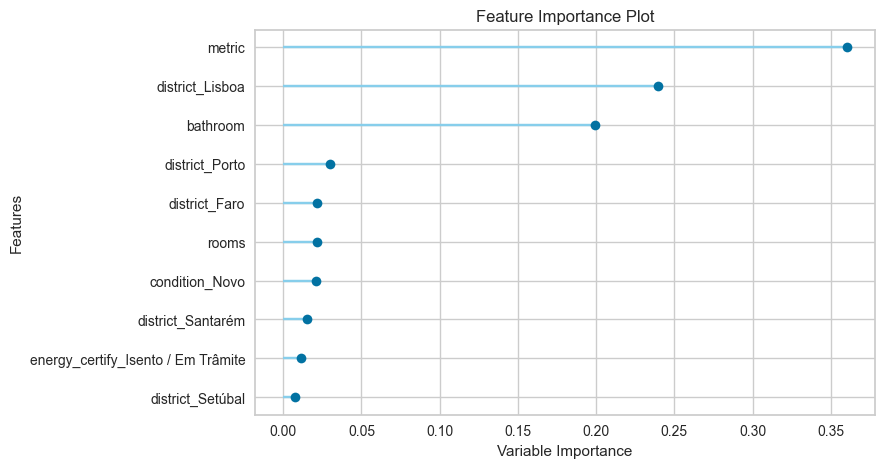

In [63]:
plot_model(best, plot = 'feature')


In [64]:
# finalize the model
final_best = finalize_model(best)

In [65]:
final_best

Pipeline(memory=FastMemory(location=C:\Users\MARCOS~1\AppData\Local\Temp\joblib),
         steps=[('target_transformation',
                 TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                ('numerical_imputer',
                 TransformerWrapper(include=['metric', 'rooms', 'bathroom'],
                                    transformer=SimpleImputer())),
                ('categorical_impute...
                                                                         'mapping': apartamento    0
moradia        1
NaN           -1
dtype: int64}]))),
                ('onehot_encoding',
                 TransformerWrapper(include=['energy_certify', 'district',
                                             'condition', 'property_ads'],
                                    transformer=OneHotEncoder(cols=['energy_certify',
                                                                    'district',
                                                                    'condition',
                                                                    'property_ads'],
                                                              handle_missing='return_nan',
                                                              use_cat_names=True))),
                ('actual_estimator',
                 GradientBoostingRegressor(random_state=6341))])

In [66]:
y_pred = final_best.predict(X_val.drop(['description', 'company', 'location'], axis=1))

In [67]:
y_pred.isna().sum()

0

In [68]:
y_pred

0       2149.897813
1       2484.451779
2       2804.310517
3       1610.993707
4        892.357558
           ...     
1116    1251.802785
1117     847.902807
1118    1074.154380
1119    1851.446111
1120    1211.126465
Name: Price, Length: 1121, dtype: float64

In [69]:
mean_squared_error(y_val, round(y_pred), squared=False)

34345.2465525129

In [70]:
y_val

0         1600
1         1850
2         5950
3         2200
4         1200
         ...  
1116      1250
1117       650
1118    153700
1119      1750
1120       800
Name: price, Length: 1121, dtype: int32

In [71]:
round(y_pred)

0       2150.0
1       2484.0
2       2804.0
3       1611.0
4        892.0
         ...  
1116    1252.0
1117     848.0
1118    1074.0
1119    1851.0
1120    1211.0
Name: Price, Length: 1121, dtype: float64

In [72]:
r2_score(y_val, round(y_pred))

-0.004113741340350918

In [ ]:
# https://towardsdatascience.com/easy-mlops-with-pycaret-mlflow-7fbcbf1e38c6